In [35]:
import os
import random
import logging

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import mlflow
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.optim import Adam

from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [24]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [25]:
device

'mps'

In [26]:
os.environ['USER'] = 'Maks Kucher'

In [27]:
train_mnist = datasets.MNIST('data_mnist/train', train=True, 
                                                transform=transforms.Compose([transforms.ToTensor()]),  
                                                download=True)
val_mnist = datasets.MNIST('data_mnist/test', train=False, 
                                               transform=transforms.Compose([transforms.ToTensor()]), 
                                               download=True)

In [28]:
len(train_mnist), len(val_mnist)

(60000, 10000)

In [29]:
batch_size = 128

train_dl = DataLoader(
                 dataset=train_mnist,
                 batch_size=batch_size,
                 shuffle=True)
val_dl = DataLoader(
                dataset=val_mnist,
                batch_size=batch_size,
                shuffle=False)

In [30]:
class Net(nn.Module):
    def __init__(self, drop_value, n_inside):
        super(Net, self).__init__() 
        self.linear1 = nn.Linear(784, n_inside)
        self.linear2 = nn.Linear(n_inside, 10)
        
        self.dropout = nn.Dropout(p = drop_value)

    def forward(self, x):
        x = x.view(-1,28*28)
        out = self.linear1(self.dropout(x))
        out = F.relu(out)
        y = self.linear2(out)
        return y

In [31]:
model = Net(0.3, 512)
tensor = torch.randn(1, 1, 28, 28)

out = model(tensor)
out.shape

torch.Size([1, 10])

In [59]:
def train(model, train_dl, val_dl, optimizer, loss_fn, accuracy, f1, epochs, device):
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],

        "val_loss": [],
        "val_acc": [],
        "val_f1": []
    }

    max_acc = 0

    for epoch in range(epochs):

        model.train()
        total_train_loss = 0.0
        total_train_labels = []
        total_train_preds = []

        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            preds = model(x)

            loss = loss_fn(preds, y)

            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            upd_preds = torch.argmax(preds, dim=1)

            total_train_labels.extend(y.cpu().numpy())
            total_train_preds.extend(upd_preds.cpu().numpy())

        train_acc = accuracy(total_train_labels, total_train_preds)
        train_f1 = f1(total_train_labels, total_train_preds, average="macro")
        total_train_loss /= len(train_dl)

        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("train_f1", train_f1, step=epoch)
        mlflow.log_metric("train_loss", total_train_loss, step=epoch)

        model.eval()
        total_val_loss = 0.0
        total_val_labels = []
        total_val_preds = []

        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)

                preds = model(x)
                loss = loss_fn(preds, y)
                total_val_loss += loss.item()

                upd_preds = torch.argmax(preds, dim=1)
                
                total_val_labels.extend(y.cpu().numpy())
                total_val_preds.extend(upd_preds.cpu().numpy())

        total_val_loss /= len(val_dl)
        val_acc = accuracy(total_val_labels, total_val_preds)
        val_f1 = f1(total_val_labels, total_val_preds, average="macro")

        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        mlflow.log_metric("val_loss", total_val_loss, step=epoch)

        if val_acc > max_acc:
            max_acc = val_acc
            mlflow.pytorch.log_model(model, "model")



        history["train_loss"].append(total_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        

        history["val_loss"].append(total_val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        

        print(f'Epoch: {epoch+1}; Loss: {total_train_loss:.4f}; Accuracy: {train_acc:.4f}; F1_score: {train_f1:.4f}; Val_loss: {total_val_loss:.4f}; Val_acc: {val_acc:.4f}; Val_f1: {val_f1:.4f}')

    torch.save(model.state_dict(), "best_model.pt")
    mlflow.log_artifact("best_model.pt")


    print(f'max accuracy = {max_acc}')
    mlflow.log_metric("max val accuracy", max_acc)
    mlflow.end_run()
    
    return history

In [ ]:
# mlflow server \
#   --backend-store-uri "/Users/maxkucher/Desktop/server/data_local" \
#   --default-artifact-root "/Users/maxkucher/Desktop/server/artefacts" \
#   --port 5000

In [33]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("PyTorch_test")

2025/08/29 20:20:52 INFO mlflow.tracking.fluent: Experiment with name 'PyTorch_test' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/maxkucher/Desktop/server/artefacts/189881219186451035', creation_time=1756488052603, experiment_id='189881219186451035', last_update_time=1756488052603, lifecycle_stage='active', name='PyTorch_test', tags={}>

In [60]:
def run(run_name, train_dl, val_dl, optimizer, loss_fn, lr, accuracy, f1, epochs, drop_value, n_inside, device):
    with mlflow.start_run(run_name=run_name):

        model = Net(drop_value, n_inside)

        mlflow.log_param("dropout_value", drop_value)
        mlflow.log_param("neuros_inside", n_inside)

        model.to(device)
        
        optim = optimizer(model.parameters(), lr=lr)

        optim_name = optim.__class__.__name__


        mlflow.log_param("optimizer", optim_name)
        mlflow.log_param("epochs", epochs)
        
        history = train(model, train_dl, val_dl, optim, loss_fn, accuracy, f1, epochs, device)
        history = 0
        return history
        

In [61]:
loss_fn = nn.CrossEntropyLoss()
lr = 4e-3
drop_value = 0.2
n_inside = 256
epochs = 8
device = device

history = run("run_4", train_dl, val_dl, Adam, loss_fn, lr, accuracy_score, f1_score, epochs, drop_value, n_inside, device)

100%|██████████| 79/79 [00:00<00:00, 145.41it/s]
/opt/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Epoch: 1; Loss: 0.2627; Accuracy: 0.9207; F1_score: 0.9197; Val_loss: 0.1393; Val_acc: 0.9580; Val_f1: 0.9574


100%|██████████| 79/79 [00:00<00:00, 192.07it/s]


Epoch: 2; Loss: 0.1210; Accuracy: 0.9632; F1_score: 0.9629; Val_loss: 0.0897; Val_acc: 0.9726; Val_f1: 0.9725


100%|██████████| 79/79 [00:00<00:00, 195.38it/s]


Epoch: 3; Loss: 0.0895; Accuracy: 0.9716; F1_score: 0.9714; Val_loss: 0.0745; Val_acc: 0.9756; Val_f1: 0.9755


100%|██████████| 79/79 [00:00<00:00, 198.02it/s]


Epoch: 4; Loss: 0.0733; Accuracy: 0.9765; F1_score: 0.9763; Val_loss: 0.0773; Val_acc: 0.9761; Val_f1: 0.9760


100%|██████████| 79/79 [00:00<00:00, 196.85it/s]


Epoch: 5; Loss: 0.0676; Accuracy: 0.9792; F1_score: 0.9791; Val_loss: 0.0698; Val_acc: 0.9784; Val_f1: 0.9783


100%|██████████| 79/79 [00:00<00:00, 195.18it/s]


Epoch: 6; Loss: 0.0584; Accuracy: 0.9811; F1_score: 0.9810; Val_loss: 0.0711; Val_acc: 0.9777; Val_f1: 0.9775


100%|██████████| 79/79 [00:00<00:00, 183.48it/s]


Epoch: 7; Loss: 0.0528; Accuracy: 0.9826; F1_score: 0.9825; Val_loss: 0.0735; Val_acc: 0.9801; Val_f1: 0.9800


100%|██████████| 79/79 [00:00<00:00, 198.93it/s]


Epoch: 8; Loss: 0.0482; Accuracy: 0.9844; F1_score: 0.9843; Val_loss: 0.0667; Val_acc: 0.9793; Val_f1: 0.9792
max accuracy = 0.9801


In [64]:
model_uri = 'runs:/66c259bc26f24804bddd34f33b3b6ed9/model'

In [70]:
def load_model(model_uri):
    model = mlflow.pytorch.load_model(model_uri)
    model.eval()
    return model

In [71]:
model = load_model(model_uri)
model.to(device)

Net(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [72]:
tensor = torch.randn(1, 1, 28, 28).to(device)

In [73]:
model.eval()
with torch.no_grad():
    out = model(tensor)
out.shape

torch.Size([1, 10])

In [88]:
def output_preds(data, limit, model):
    for i, (x, _) in enumerate(data):
        x_val = x.to(device)
        x = x.permute(1, 2, 0).cpu().numpy()

        with torch.no_grad():
            pred = model(x_val)

        pred = torch.argmax(pred, dim=1)
        
        plt.imshow(x)
        plt.title(pred.item())
        plt.axis("off")
        plt.show()

        if i+1 == limit:
            break


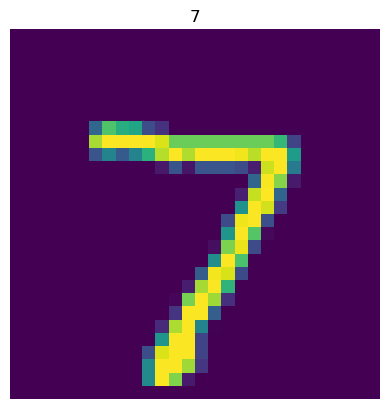

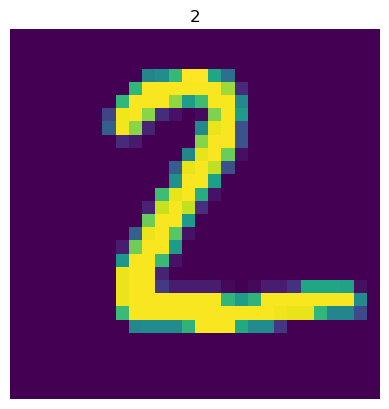

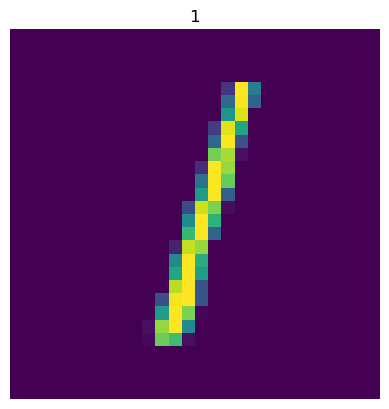

In [89]:
output_preds(val_mnist, 3, model)

In [90]:
# if model is registered in MLFlow

model_uri = "models:/digits_recognizer/latest"
new_model = load_model(model_uri)
new_model.to(device)

/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


Net(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
/Users/maxkucher/preprocessing/mlops/pytorch_mlflow_basic.ipynb

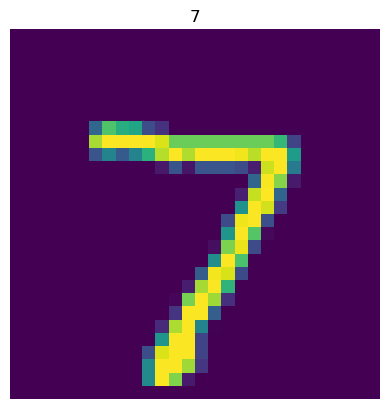

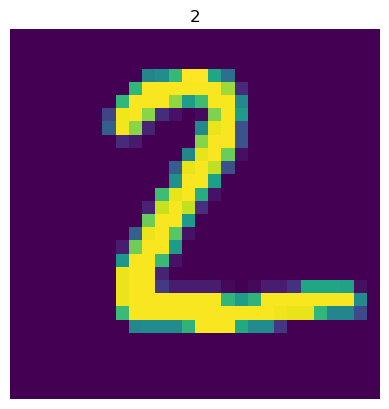

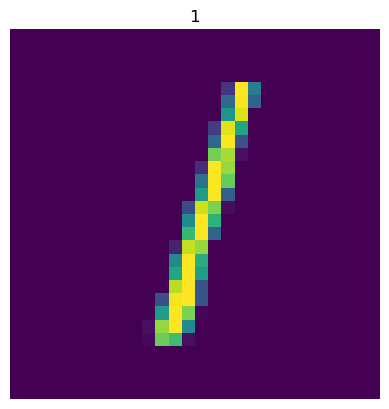

In [91]:
output_preds(val_mnist, 3, new_model)